# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [ ]:
!pip install -r /content/requirements.txt

In [ ]:
!pip install kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir -p ~/ .kaggle

In [6]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/

In [7]:
!chmod 600 ~/ .kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

In [ ]:
!unzip /content/semantic-segmentation-of-aerial-imagery.zip

In [10]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [11]:
import tensorflow as tf
print(tf.__version__)
tf.random.set_seed(42)

2.12.1


In [12]:
PATH  = "/content/Semantic segmentation dataset"

In [13]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

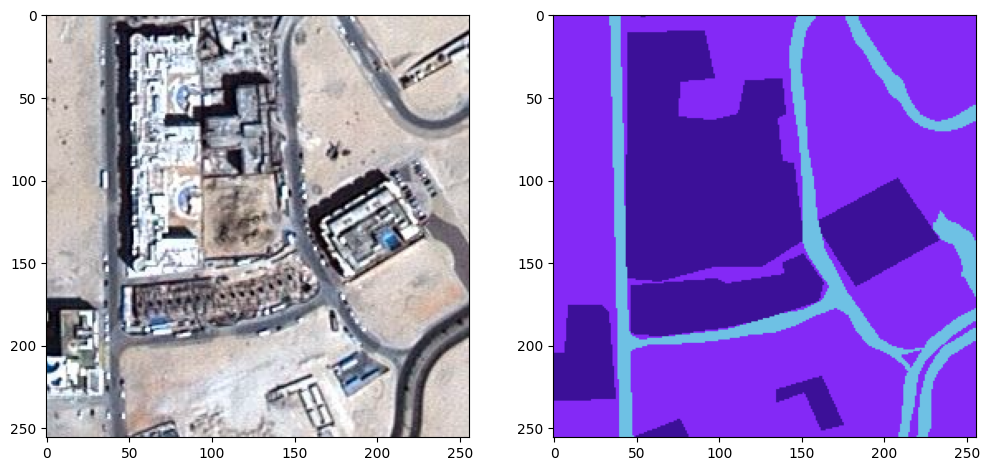

In [14]:
PATCH_GENERATOR.check()

In [15]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels

In [16]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [17]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [18]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [19]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [20]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


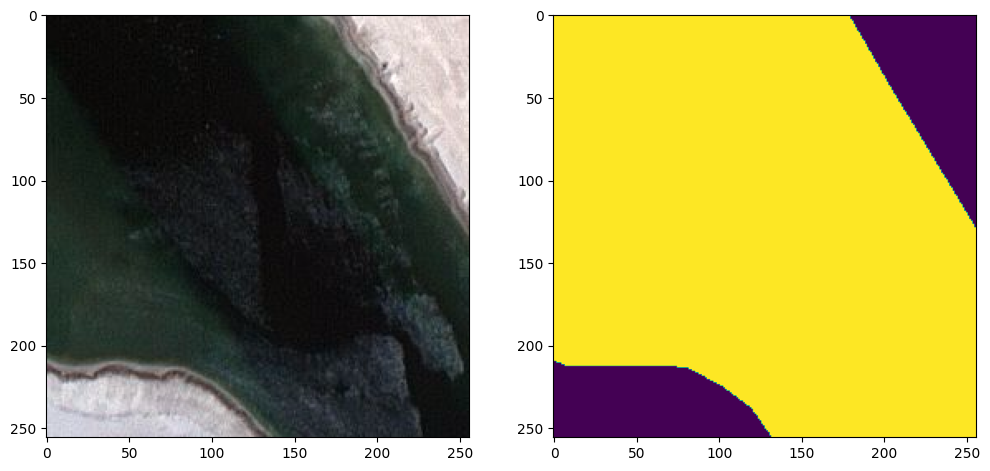

In [21]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Modelling section

In [22]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

Let's create another splitting for the hyperparameters

In [27]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

## NEXT STEPS:

- Grid search for hyperparameter tuning following university procedure;
- review U-net concepts
- compare with other pretrained models


# Choosing hyperparameters

1. Check initial Loss (Turn off weight decay, sanity check loss at initialization)
2. Overfit a small sample (try to train to 100% training accuracy on a small sample of training data, approx. 5-10 minibatches)
    1. Fiddle with architecture, learning rate, weight initialization;
    2. some common problems:
        1. Loss is not going down: LR too low, or bad initialization;
        2. Loss explodes to Inf or Nan: LR too high, bad initialization
3. Use all the training data, turn on small weight decay, find the learning rate that makes the loss drop significantly  withing 100 iterations ( use the same architecture obtained in the previous step);
    1. good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4
4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs
    1. good weight decay to try: 1e-4, 1e-5, 0
5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.
6. Measure their performances using loss and accuracy curves
  1. Accuracy is still going up, train the models more;
  2. Huge train/ val gap means overfiiting: increase regularization or more data
  3. No gap betwee train/val means underfitting: train longer or a bigger model
7. Go back to step 5 if needed (train again with the little updates on the architecture, no need to go back to 1 since i have already a good starting point when i reached 5)

In [29]:
_, sample_imgs, y_, sample_labels = train_test_split(X_train, y_train, test_size = 0.005, random_state = 42)

In [28]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


1. Check initial loss

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history1 = model.fit(X_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=1,
                    shuffle=False)

In [ ]:
tf.keras.backend.clear_session()

2. Overfit a small sample

In [ ]:
sample_imgs.shape

(6, 256, 256, 3)

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history2 = model.fit(sample_imgs, sample_labels,
                    batch_size = 32,
                    verbose=1,
                    epochs=1000,
                    shuffle=False)

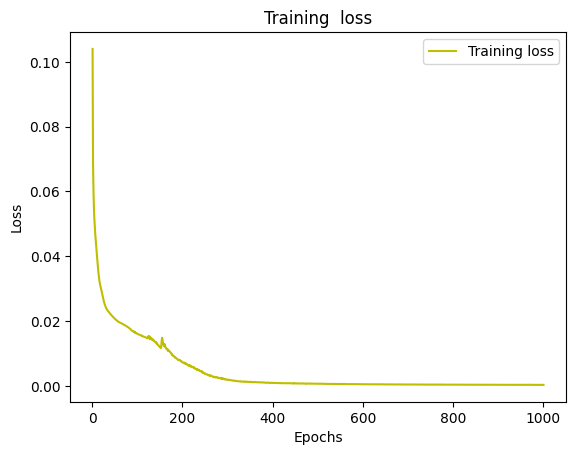

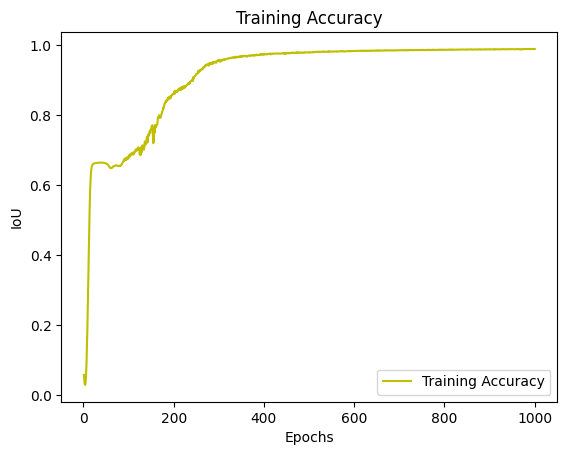

In [ ]:
history = history2
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

3. Grid-Search (for 100 iterations). Find the set of hyperparameters that make the loss drop significantly

In [30]:
X_train.shape

(1044, 256, 256, 3)

In [31]:
X_train2.shape

(835, 256, 256, 3)

In [32]:
import math
# dividing by 2 due to the cv
num_samples = 835
batch_size = 32

# Calculate the number of epochs to reach the total iterations
batches_per_epoch = math.ceil(num_samples / batch_size) # this is equal to the number of iteration in a epoch
batches_per_epoch

27

In [34]:
# Function used for Grid-search
def define_model(optimizer):
    model = multi_unet_model()
    model.compile(optimizer = optimizer, loss=sm.losses.CategoricalFocalLoss(), metrics=['accuracy'])
    return model


We can't use keras wrapper and grid search here due to shape constraints.

In fact, it is thought for 1D input/output.

We need to do sth else here!
https://adriangb.com/scikeras/stable/notebooks/DataTransformers.html

In [ ]:
import gc
import wandb
# WandbCallback will automatically log history data from any metrics collected by keras: loss and anything passed into keras_model.compile().
from wandb.integration.keras import WandbCallback
from sklearn.model_selection import ParameterGrid

param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
}

results = []
NAME = "GRID_SEARCH_STEP3_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="SemanticSegmentationProject",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train2, y_train2,validation_data = (X_val, y_val), epochs=3, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()


4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs

In [39]:
learning_rate = 0.001 # Chosen lr
multipliers = [0.5, 0.80, 1.0, 1.25, 1.5]

learning_rates = [learning_rate * m for m in multipliers]

learning_rates

[0.0005, 0.0008, 0.001, 0.00125, 0.0015]

In [ ]:
param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': learning_rates,
}

results = []
NAME = "GRID_SEARCH_STEP4_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="SemanticSegmentationProject",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train, y_train,validation_data = (X_val, y_val), epochs=5, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()


5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.

In [41]:
param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': [0.0015,0.00125],
}

results = []
NAME = "GRID_SEARCH_STEP5_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="SemanticSegmentationProject",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train, y_train,validation_data = (X_val, y_val), epochs=20, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()

Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.0015}


Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.4945

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 70s 2s/step - loss: 0.0324 - accuracy: 0.4945 - val_loss: 0.0284 - val_accuracy: 0.5934
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.6142

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 65s 2s/step - loss: 0.0263 - accuracy: 0.6142 - val_loss: 0.0222 - val_accuracy: 0.6420
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.6606

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0218 - accuracy: 0.6606 - val_loss: 0.0207 - val_accuracy: 0.6751
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.6956

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 65s 2s/step - loss: 0.0199 - accuracy: 0.6956 - val_loss: 0.0182 - val_accuracy: 0.7042
Epoch 5/20
33/33 [==============================] - 60s 2s/step - loss: 0.0185 - accuracy: 0.7181 - val_loss: 0.0209 - val_accuracy: 0.6930
Epoch 6/20
33/33 [==============================] - 60s 2s/step - loss: 0.0171 - accuracy: 0.7293 - val_loss: 0.0186 - val_accuracy: 0.7141
Epoch 7/20
33/33 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.7389

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0166 - accuracy: 0.7389 - val_loss: 0.0165 - val_accuracy: 0.7405
Epoch 8/20
33/33 [==============================] - 59s 2s/step - loss: 0.0154 - accuracy: 0.7509 - val_loss: 0.0181 - val_accuracy: 0.7275
Epoch 9/20
33/33 [==============================] - 59s 2s/step - loss: 0.0145 - accuracy: 0.7655 - val_loss: 0.0213 - val_accuracy: 0.7094
Epoch 10/20
33/33 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.7716

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0141 - accuracy: 0.7716 - val_loss: 0.0146 - val_accuracy: 0.7753
Epoch 11/20
33/33 [==============================] - 59s 2s/step - loss: 0.0145 - accuracy: 0.7674 - val_loss: 0.0170 - val_accuracy: 0.7561
Epoch 12/20
33/33 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.7773

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0139 - accuracy: 0.7773 - val_loss: 0.0142 - val_accuracy: 0.7783
Epoch 13/20
33/33 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.7867

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0132 - accuracy: 0.7867 - val_loss: 0.0138 - val_accuracy: 0.7800
Epoch 14/20
33/33 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.7800

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 65s 2s/step - loss: 0.0136 - accuracy: 0.7800 - val_loss: 0.0127 - val_accuracy: 0.7967
Epoch 15/20
33/33 [==============================] - 59s 2s/step - loss: 0.0130 - accuracy: 0.7902 - val_loss: 0.0156 - val_accuracy: 0.7628
Epoch 16/20
33/33 [==============================] - 59s 2s/step - loss: 0.0126 - accuracy: 0.7963 - val_loss: 0.0130 - val_accuracy: 0.7873
Epoch 17/20
33/33 [==============================] - 60s 2s/step - loss: 0.0121 - accuracy: 0.8034 - val_loss: 0.0143 - val_accuracy: 0.7891
Epoch 18/20
33/33 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.8113

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0116 - accuracy: 0.8113 - val_loss: 0.0126 - val_accuracy: 0.7968
Epoch 19/20
33/33 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.8076

wandb: Adding directory to artifact (/content/wandb/run-20240625_094038-jp1rlsaw/files/model-best)... Done. 0.1s


33/33 [==============================] - 65s 2s/step - loss: 0.0117 - accuracy: 0.8076 - val_loss: 0.0123 - val_accuracy: 0.7979
Epoch 20/20
33/33 [==============================] - 59s 2s/step - loss: 0.0116 - accuracy: 0.8090 - val_loss: 0.0131 - val_accuracy: 0.7985


accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▅▄▅▆▆▅▇▇▇▇█▇█████
val_loss,█▅▅▄▅▄▃▄▅▂▃▂▂▁▂▁▂▁▁▁
accuracy,0.80899
best_epoch,18
best_val_loss,0.0123
epoch,19
loss,0.01161
val_accuracy,0.7985


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.00125}


Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.4742

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 69s 2s/step - loss: 0.0345 - accuracy: 0.4742 - val_loss: 0.0287 - val_accuracy: 0.5354
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.5768

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0285 - accuracy: 0.5768 - val_loss: 0.0250 - val_accuracy: 0.6460
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.6466

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0237 - accuracy: 0.6466 - val_loss: 0.0211 - val_accuracy: 0.6828
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.6940

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0205 - accuracy: 0.6940 - val_loss: 0.0200 - val_accuracy: 0.7025
Epoch 5/20
33/33 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.7270

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0185 - accuracy: 0.7270 - val_loss: 0.0165 - val_accuracy: 0.7540
Epoch 6/20
33/33 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.7526

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0170 - accuracy: 0.7526 - val_loss: 0.0157 - val_accuracy: 0.7675
Epoch 7/20
33/33 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.7639

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0158 - accuracy: 0.7639 - val_loss: 0.0154 - val_accuracy: 0.7626
Epoch 8/20
33/33 [==============================] - 59s 2s/step - loss: 0.0145 - accuracy: 0.7763 - val_loss: 0.0155 - val_accuracy: 0.7699
Epoch 9/20
33/33 [==============================] - 59s 2s/step - loss: 0.0139 - accuracy: 0.7851 - val_loss: 0.0158 - val_accuracy: 0.7678
Epoch 10/20
33/33 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.7938

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0131 - accuracy: 0.7938 - val_loss: 0.0129 - val_accuracy: 0.7955
Epoch 11/20
33/33 [==============================] - 59s 2s/step - loss: 0.0137 - accuracy: 0.7840 - val_loss: 0.0142 - val_accuracy: 0.7811
Epoch 12/20
33/33 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.7952

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 65s 2s/step - loss: 0.0129 - accuracy: 0.7952 - val_loss: 0.0128 - val_accuracy: 0.7891
Epoch 13/20
33/33 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.8025

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0122 - accuracy: 0.8025 - val_loss: 0.0116 - val_accuracy: 0.8055
Epoch 14/20
33/33 [==============================] - 59s 2s/step - loss: 0.0121 - accuracy: 0.8038 - val_loss: 0.0137 - val_accuracy: 0.7856
Epoch 15/20
33/33 [==============================] - 60s 2s/step - loss: 0.0123 - accuracy: 0.8036 - val_loss: 0.0150 - val_accuracy: 0.7719
Epoch 16/20
33/33 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.8116

wandb: Adding directory to artifact (/content/wandb/run-20240625_100143-e91b19ud/files/model-best)... Done. 0.1s


33/33 [==============================] - 64s 2s/step - loss: 0.0116 - accuracy: 0.8116 - val_loss: 0.0116 - val_accuracy: 0.8033
Epoch 17/20
33/33 [==============================] - 59s 2s/step - loss: 0.0119 - accuracy: 0.8078 - val_loss: 0.0140 - val_accuracy: 0.7867
Epoch 18/20
33/33 [==============================] - 59s 2s/step - loss: 0.0109 - accuracy: 0.8212 - val_loss: 0.0118 - val_accuracy: 0.8041
Epoch 19/20
33/33 [==============================] - 59s 2s/step - loss: 0.0106 - accuracy: 0.8250 - val_loss: 0.0121 - val_accuracy: 0.8033
Epoch 20/20
33/33 [==============================] - 59s 2s/step - loss: 0.0104 - accuracy: 0.8257 - val_loss: 0.0118 - val_accuracy: 0.8107


accuracy,▁▃▄▅▆▇▇▇▇▇▇▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁
val_accuracy,▁▄▅▅▇▇▇▇▇█▇▇█▇▇█▇███
val_loss,█▇▅▄▃▃▃▃▃▂▂▁▁▂▂▁▂▁▁▁
accuracy,0.82575
best_epoch,15
best_val_loss,0.0116
epoch,19
loss,0.01041
val_accuracy,0.8107


6. Let's measure the performances and decide if we need to train longer or to change the architecture a little bit and go back to step 5